## Exploratory Data Analysis (EDA) of BTC/ETH prices and GoogleNews search frequency of the word "cryptocurrency"

Due to volatility of crytocurrency market, one might wonder what is the best way to predict the currencies prices. As I came up with the project idea, the preliminary questions I had in mind were:

1. Is there any obvious correlation/lead-lag relationship between different crytocurrency market prices?
2. If the correlation between a pair of currencies existed, can we use the correlation information to predict future price of a certain currency?
3. Does the rise/fall in search frequency of the word "crytocurrency" on GoogleNews imply trading signal?

The following code queries and visualize data in order to explore the preliminary questions. The stretch goal is to gain insights beyond preliminary questions that will lead to better data analysis in the future



In [1]:
# Getting price data of BTC and ETH using Cryptocompare API

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '15000' 
story_coin = ['BTC', 'ETH']
story_data = pd.DataFrame()
for i in story_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    story_data = pd.concat([story_data, table.high], axis=1)
story_data.columns = story_coin

In [2]:
# Getting data from Google Trends using Pytrends API

from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2017-02-24 2017-10-24')  

story_ggtrends = pytrend.interest_over_time()
# Upsampling daily data to hourly data
story_ggtrends = story_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
story_ggtrends.columns = ['SearchFrequency']

In [3]:
# Joining two data frames
story_combined = pd.concat([story_data, story_ggtrends], axis=1).dropna(how='any')
story_combined_scaled = story_combined.copy(deep=True)

In [4]:
# Feature Scaling. This will capture trend information and makes visualization more meaningful
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
story_combined_scaled['BTC'] = sc_x.fit_transform(story_combined_scaled['BTC'].values.reshape(-1,1))
story_combined_scaled['ETH'] = sc_x.fit_transform(story_combined_scaled['ETH'].values.reshape(-1,1))
story_combined_scaled['SearchFrequency'] = sc_x.fit_transform(story_combined_scaled['SearchFrequency'].values.reshape(-1,1))


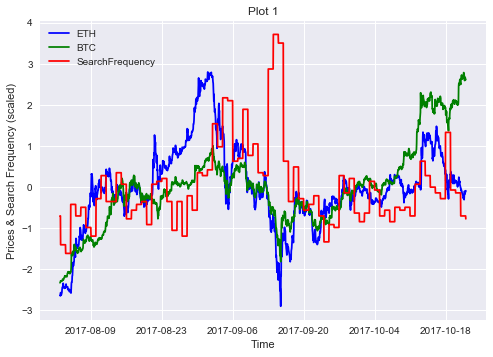

In [5]:
# Plot 1- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
#plt.xlim(('2017-07-26', '2017-10-10'))
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 1')
plt.show()

From **Plot 1**, I've obsereved the following:
1. Sharp rises in search frequency are coupled with price drops
2. BTC and ETH prices tend to converge during drops, and not spikes (notice that the seriese were scaled) 

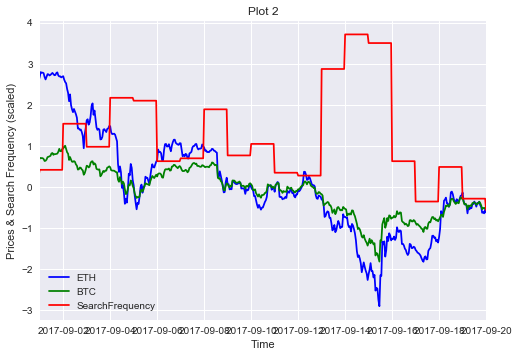

In [6]:
# Plot 2- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data in 20 days timespand (during drop)

plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
plt.xlim(('2017-09-01', '2017-09-20'))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 2')
plt.show()

According to **Plot 2**, it looks like sharp rise in search frequency leads ETH/BTC price drop. However, this conclusion is based on just 2 events

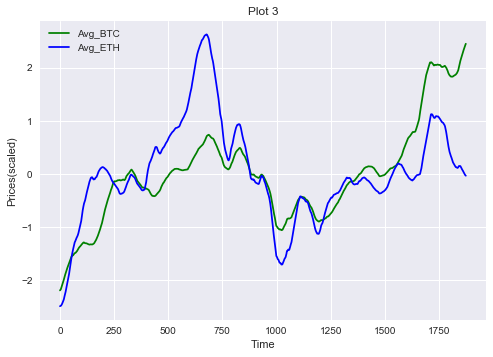

In [48]:
# Plot 3- BTC/ETH moving averages (scaled)
from ipykernel import kernelapp as app
import numpy as np
a = 50
b = a-1
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma_combined = pd.DataFrame()
ma_combined['ETH'] = moving_average(story_combined_scaled['ETH'].values, a)
ma_combined['BTC'] = moving_average(story_combined_scaled['BTC'].values, a)

plt.plot(ma_combined.index, ma_combined['BTC'], color='green', label = 'Avg_BTC')
plt.plot(ma_combined.index, ma_combined['ETH'], color='blue', label = 'Avg_ETH')
plt.legend(loc='upper left')
plt.ylabel('Prices(scaled)')
plt.xlabel('Time')
plt.title('Plot 3')
plt.show()


Based on **Plot 3-4** , there seem to be correlation between ETH and BTC prices and that ETH leads BTC. However, Granger Causality Test will be performed to confirm the relationship. Concerning stationality, Dickey-Fuller test will be perfrom to detect trend (varying mean over time) or seasonality (varying variance over time) of the series. 

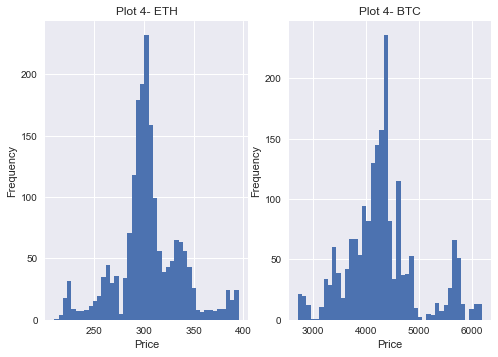

In [8]:
# Plot 4- BTC/ETH histogram
n_data = len(story_combined['ETH'])
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
story_combined['ETH'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 4- ETH', loc='center')
plt.subplot(1, 2, 2)
story_combined['BTC'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 4- BTC', loc='center')
plt.show()

**Plot 4** shows that ETH has a sharp frequency peak at ~300, while BTC doesn't have such sharp peak. Depending on personal judgement, if the ETH peak was more extreame, it might have been helpful to bias the ETH model to 300. Moreover, BTC histrogram is slightly skewed left, which may have implied BTC market is less "stable". We will further explore histograms of both series after differncing to better quantify "stability". 

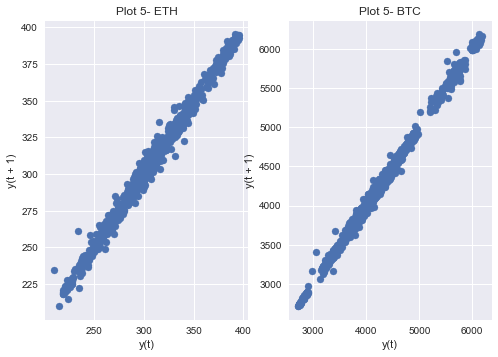

In [10]:
# Plot 5- BTC/ETH lag1 scatter plot
from pandas.plotting import lag_plot
plt.subplot(1, 2, 1)
lag_plot(story_combined['ETH'])
plt.title('Plot 5- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined['BTC'])
plt.title('Plot 5- BTC', loc='center')
plt.show()

**Plot 5** suggests positive correlation between y(t) and y(t-1) in both BTC and ETH. To further explore the series, we're going to look at Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots which measure the linear predictability of the series at time t, say x_t, using the value x_s, where s and t denote two valuation points in time. Before we explore ACF and PACF plots, we need to stationarize the series.


In [55]:
# Perform Dickey Fuller Test to determine stationality of BTC and ETC time series
from statsmodels.tsa.stattools import adfuller
x = story_combined_scaled['ETH'].values
result = adfuller(x)
print('\n')
print('ADF Statistic (ETH): %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

y = story_combined_scaled['BTC'].values
result = adfuller(y)
print('\n')
print('ADF Statistic (BTC): %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic (ETH): -2.951813
p-value: 0.039646
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (BTC): -1.036596
p-value: 0.739684
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
#stationalize

In [ ]:
#histogram of difference 

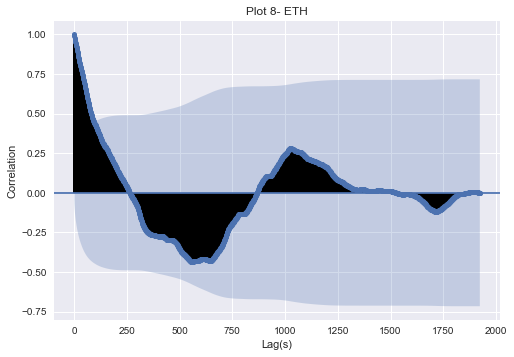

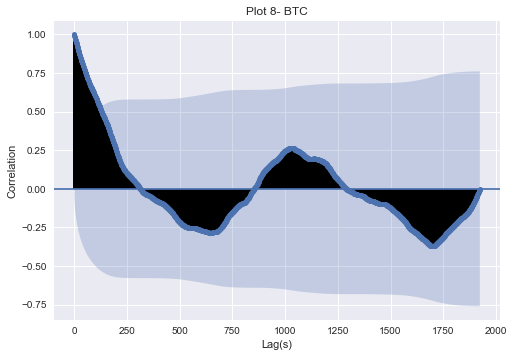

In [24]:
#acf plot
from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries

plot_acf(story_combined['ETH'])
plt.title('Plot 8- ETH', loc='center')
plt.ylabel('Correlation')
plt.xlabel('Lag(s)')
plot_acf(story_combined['BTC'])
plt.title('Plot 8- BTC', loc='center')
plt.ylabel('Correlation')
plt.xlabel('Lag(s)')
plt.show()

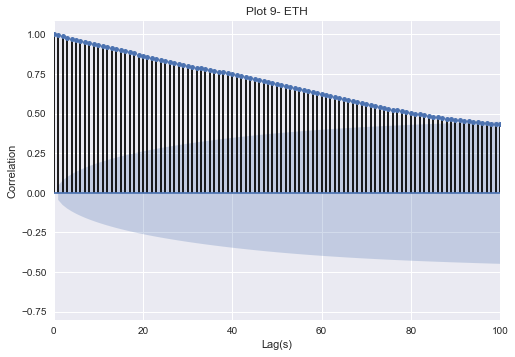

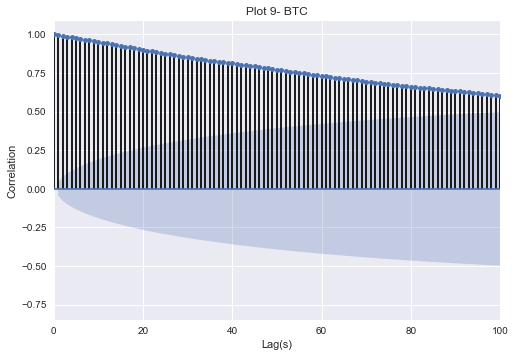

In [25]:
#close up acf plot
plot_acf(story_combined['ETH'])
plt.title('Plot 9- ETH', loc='center')
plt.xlim((0, 100))
plt.ylabel('Correlation')
plt.xlabel('Lag(s)')
plot_acf(story_combined['BTC'])
plt.title('Plot 9- BTC', loc='center')
plt.xlim((0, 100))
plt.ylabel('Correlation')
plt.xlabel('Lag(s)')
plt.show()


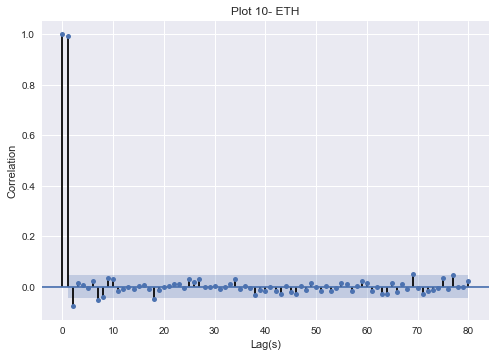

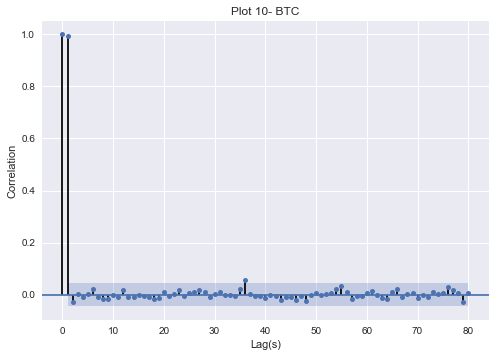

In [26]:
#pacf plot
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(story_combined['ETH'], lags=80)
plt.title('Plot 10- ETH', loc='center')
plt.ylabel('Correlation')
plt.xlabel('Lag(s)')

plot_pacf(story_combined['BTC'], lags=80)
plt.title('Plot 10- BTC', loc='center')
plt.ylabel('Correlation')
plt.xlabel('Lag(s)')
plt.show()

### Conclusion:
-  There seem to be high correlation between the rise in search frequency and the drop in currencies prices 
-  The correlation between an observation and the previous observation (lag1) improves when theres no sharp drop 
-  There seem to be correlation between BTC/ETH prices and that ETH leads BTC. A statistics test is needed to confirm the finding.
<br><br>
From the conclusion above, my hypothesis is that Autocorrelation model doesn't perform well in volatile markets. With careful use of features (i.e.GoogleNews search frequency), other Machine Learning models would better predict market volatility.

Next steps are:
1. Come up with more meaningful features
2. Confirm correlations between currencies using Granger Causality Test
3. Analyze price history using PACF 
4. Based on 1,2,3, come up with a Machine Learning model that best predict future prices